In [2]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B
Saving models to: /kaggle/working/checkpoints


In [3]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [4]:
import os

# =============================================
# AUTO-DETECT ENVIRONMENT (KAGGLE vs LOCAL)
# =============================================
if os.path.exists("/kaggle/input"):
    PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B"
    print("Running on Kaggle")
else:
    PREPROCESS_ROOT = r"E:\DeepVision Crowd Monitor Ai\preprocessed_B\preprocessed_B"
    print("Running on Local System")

print("PREPROCESS_ROOT =", PREPROCESS_ROOT)


Running on Local System
PREPROCESS_ROOT = E:\DeepVision Crowd Monitor Ai\preprocessed_B\preprocessed_B


In [5]:
###############################################
# PART-B : LOCAL SYSTEM HANDLING
###############################################
import os

# Local Part-B preprocess root
PREPROCESS_ROOT_B = r"E:\DeepVision Crowd Monitor Ai\preprocessed_B\preprocessed_B"

trainB_img_dir = os.path.join(PREPROCESS_ROOT_B, "TrainB", "images")
trainB_gt_dir  = os.path.join(PREPROCESS_ROOT_B, "TrainB", "gt")

if not os.path.exists(trainB_img_dir) or not os.path.exists(trainB_gt_dir):
    print("⚠️ Part-B training skipped (LOCAL SYSTEM)")
    print("Reason: TrainB preprocessed dataset not available locally")
    RUN_PART_B = False
else:
    print("✅ TrainB data found locally")
    RUN_PART_B = True


✅ TrainB data found locally


In [6]:
if RUN_PART_B:
    print("Running Part-B training...")
else:
    print("Part-B training not executed due to missing dataset")


Running Part-B training...


In [7]:
import os

print("PREPROCESS_ROOT:", PREPROCESS_ROOT)

print("\nFolders under PREPROCESS_ROOT:")
if os.path.exists(PREPROCESS_ROOT):
    for f in os.listdir(PREPROCESS_ROOT):
        print(" -", f)
else:
    print("❌ PREPROCESS_ROOT does not exist")

print("\nTrainB/images exists?",
      os.path.exists(os.path.join(PREPROCESS_ROOT, "TrainB", "images")))
print("TrainB/gt exists?",
      os.path.exists(os.path.join(PREPROCESS_ROOT, "TrainB", "gt")))

# Count .pt files if folders exist
train_img_path = os.path.join(PREPROCESS_ROOT, "TrainB", "images")
train_gt_path  = os.path.join(PREPROCESS_ROOT, "TrainB", "gt")

if os.path.exists(train_img_path):
    print("TrainB image .pt files:", len(os.listdir(train_img_path)))
else:
    print("❌ TrainB/images folder not found")

if os.path.exists(train_gt_path):
    print("TrainB gt .pt files:", len(os.listdir(train_gt_path)))
else:
    print("❌ TrainB/gt folder not found")


PREPROCESS_ROOT: E:\DeepVision Crowd Monitor Ai\preprocessed_B\preprocessed_B

Folders under PREPROCESS_ROOT:
 - TrainB

TrainB/images exists? True
TrainB/gt exists? True
TrainB image .pt files: 10
TrainB gt .pt files: 10


In [8]:
import os

print("PREPROCESS_ROOT =", PREPROCESS_ROOT)

print("\nFolders under PREPROCESS_ROOT:")
for f in os.listdir(PREPROCESS_ROOT):
    print(" -", f)

print("\nTrainB/images exists?",
      os.path.exists(f"{PREPROCESS_ROOT}/TrainB/images"))
print("TrainB/gt exists?",
      os.path.exists(f"{PREPROCESS_ROOT}/TrainB/gt"))


PREPROCESS_ROOT = E:\DeepVision Crowd Monitor Ai\preprocessed_B\preprocessed_B

Folders under PREPROCESS_ROOT:
 - TrainB

TrainB/images exists? True
TrainB/gt exists? True


In [9]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS (FIXED)
###############################################
from pathlib import Path

# Correct TrainB paths
train_img_dir = f"{PREPROCESS_ROOT}/TrainB/images"
train_gt_dir  = f"{PREPROCESS_ROOT}/TrainB/gt"

# List .pt files
train_imgs = sorted([str(p) for p in Path(train_img_dir).glob("*.pt")])
train_gts  = sorted([str(p) for p in Path(train_gt_dir).glob("*.pt")])

# Verify counts
print("Total image files in TrainB:", len(train_imgs))
print("Total GT files in TrainB   :", len(train_gts))

# Sanity check
assert len(train_imgs) > 0, "❌ No TrainB images found"
assert len(train_imgs) == len(train_gts), "❌ Image/GT mismatch"

# Safe validation split (minimum 1)
num = len(train_imgs)
val_num = max(1, num // 10)

print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]
val_imgs_split   = train_imgs[-val_num:]
val_gts_split    = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Safely read GT size
sample = train_ds[0]
if isinstance(sample, tuple):
    _, sample_gt = sample
else:
    sample_gt = sample

GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files in TrainB: 10
Total GT files in TrainB   : 10
Validation size: 1
Training samples: 9
Validation samples: 1
GT shape detected: 64 x 64


In [10]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# CSRNET MODEL 
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Wrapper to match GT size
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

model = CSRNetWrapper(CSRNet(), GT_H, GT_W).cuda()
print("Model loaded.")


Train batches: 2
Val batches: 1


e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded.


In [11]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 200
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 200 epochs...


In [19]:
###############################################
# 6) TRAINING LOOP (100 EPOCHS)
###############################################
for epoch in range(1, NUM_EPOCHS+1):

    # TRAIN
    model.train()
    train_loss = 0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)
        loss = criterion(preds, gts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, gts = imgs.cuda(), gts.cuda()
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

    # Save every 20 epochs
    if epoch % 20 == 0:
        ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, ckpt_path)
        print("Saved:", ckpt_path)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = f"{CHECKPOINT_DIR}/best_model.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, best_path)
        print("BEST model saved:", best_path)

# Save final model
final_path = f"{CHECKPOINT_DIR}/final_epoch100.pth"
torch.save({"epoch": 100, "model_state": model.state_dict()}, final_path)
print("FINAL model saved:", final_path)


Epoch 1 Val: 100%|██████████| 1/1 [00:00<00:00, 18.93it/s]


Epoch 1: Train=0.267408  Val=0.259748
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 2 Val: 100%|██████████| 1/1 [00:00<00:00, 20.06it/s]


Epoch 2: Train=0.261314  Val=0.250986
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 3 Val: 100%|██████████| 1/1 [00:00<00:00, 19.25it/s]


Epoch 3: Train=0.247741  Val=0.240404
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 4 Val: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]


Epoch 4: Train=0.238569  Val=0.228380
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 5 Val: 100%|██████████| 1/1 [00:00<00:00, 18.47it/s]


Epoch 5: Train=0.227036  Val=0.213116
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 6 Val: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Epoch 6: Train=0.212470  Val=0.194505
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 7 Val: 100%|██████████| 1/1 [00:00<00:00, 18.27it/s]


Epoch 7: Train=0.191333  Val=0.172070
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 8 Val: 100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


Epoch 8: Train=0.167239  Val=0.145810
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 9 Val: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 9: Train=0.141564  Val=0.117841
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 10 Val: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 10: Train=0.111121  Val=0.095128
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 11 Val: 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]


Epoch 11: Train=0.094696  Val=0.091794
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 12 Val: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 12: Train=0.094818  Val=0.108160


Epoch 13 Val: 100%|██████████| 1/1 [00:00<00:00, 20.46it/s]


Epoch 13: Train=0.107813  Val=0.108301


Epoch 14 Val: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Epoch 14: Train=0.103285  Val=0.096519


Epoch 15 Val: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 15: Train=0.092624  Val=0.089111
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 16 Val: 100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


Epoch 16: Train=0.087669  Val=0.088535
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 17 Val: 100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


Epoch 17: Train=0.089979  Val=0.090586


Epoch 18 Val: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 18: Train=0.092087  Val=0.091843


Epoch 19 Val: 100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


Epoch 19: Train=0.091093  Val=0.091193


Epoch 20 Val: 100%|██████████| 1/1 [00:00<00:00, 19.24it/s]


Epoch 20: Train=0.090607  Val=0.089157
Saved: /kaggle/working/checkpoints/checkpoint_epoch20.pth


Epoch 21 Val: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 21: Train=0.088404  Val=0.087161
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 22 Val: 100%|██████████| 1/1 [00:00<00:00, 21.31it/s]


Epoch 22: Train=0.086174  Val=0.086732
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 23 Val: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch 23: Train=0.086772  Val=0.087683


Epoch 24 Val: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Epoch 24: Train=0.087504  Val=0.087898


Epoch 25 Val: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 25: Train=0.088169  Val=0.086912


Epoch 26 Val: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Epoch 26: Train=0.085707  Val=0.085918
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 27 Val: 100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


Epoch 27: Train=0.084980  Val=0.085583
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 28 Val: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]


Epoch 28: Train=0.087342  Val=0.085624


Epoch 29 Val: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch 29: Train=0.087417  Val=0.085552
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 30 Val: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Epoch 30: Train=0.086097  Val=0.085249
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 31 Val: 100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


Epoch 31: Train=0.085761  Val=0.085009
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 32 Val: 100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Epoch 32: Train=0.085084  Val=0.085076


Epoch 33 Val: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]


Epoch 33: Train=0.084661  Val=0.085104


Epoch 34 Val: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]


Epoch 34: Train=0.085208  Val=0.084866
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 35 Val: 100%|██████████| 1/1 [00:00<00:00, 18.99it/s]


Epoch 35: Train=0.084063  Val=0.084570
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 36 Val: 100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Epoch 36: Train=0.083846  Val=0.084386
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 37 Val: 100%|██████████| 1/1 [00:00<00:00, 19.02it/s]


Epoch 37: Train=0.084022  Val=0.084299
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 38 Val: 100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


Epoch 38: Train=0.086025  Val=0.084194
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 39 Val: 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


Epoch 39: Train=0.083858  Val=0.084060
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 40 Val: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s]


Epoch 40: Train=0.084515  Val=0.083974
Saved: /kaggle/working/checkpoints/checkpoint_epoch40.pth
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 41 Val: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Epoch 41: Train=0.084473  Val=0.083980


Epoch 42 Val: 100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


Epoch 42: Train=0.084638  Val=0.083919
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 43 Val: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 43: Train=0.084348  Val=0.083750
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 44 Val: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 44: Train=0.085436  Val=0.083608
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 45 Val: 100%|██████████| 1/1 [00:00<00:00, 20.53it/s]


Epoch 45: Train=0.084149  Val=0.083530
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 46 Val: 100%|██████████| 1/1 [00:00<00:00, 19.85it/s]


Epoch 46: Train=0.083760  Val=0.083459
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 47 Val: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]


Epoch 47: Train=0.083674  Val=0.083393
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 48 Val: 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


Epoch 48: Train=0.085166  Val=0.083361
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 49 Val: 100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


Epoch 49: Train=0.082928  Val=0.083318
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 50 Val: 100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


Epoch 50: Train=0.082991  Val=0.083234
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 51 Val: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


Epoch 51: Train=0.082810  Val=0.083162
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 52 Val: 100%|██████████| 1/1 [00:00<00:00, 26.53it/s]


Epoch 52: Train=0.083702  Val=0.083117
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 53 Val: 100%|██████████| 1/1 [00:00<00:00, 20.54it/s]


Epoch 53: Train=0.082722  Val=0.083088
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 54 Val: 100%|██████████| 1/1 [00:00<00:00, 23.52it/s]


Epoch 54: Train=0.083568  Val=0.083089


Epoch 55 Val: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Epoch 55: Train=0.083622  Val=0.083104


Epoch 56 Val: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]


Epoch 56: Train=0.082650  Val=0.083043
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 57 Val: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


Epoch 57: Train=0.084838  Val=0.082965
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 58 Val: 100%|██████████| 1/1 [00:00<00:00, 21.11it/s]


Epoch 58: Train=0.083143  Val=0.082934
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 59 Val: 100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


Epoch 59: Train=0.083127  Val=0.082908
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 60 Val: 100%|██████████| 1/1 [00:00<00:00, 23.87it/s]


Epoch 60: Train=0.083387  Val=0.082919
Saved: /kaggle/working/checkpoints/checkpoint_epoch60.pth


Epoch 61 Val: 100%|██████████| 1/1 [00:00<00:00, 22.72it/s]


Epoch 61: Train=0.083499  Val=0.082970


Epoch 62 Val: 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


Epoch 62: Train=0.084776  Val=0.082906
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 63 Val: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]


Epoch 63: Train=0.084713  Val=0.082825
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 64 Val: 100%|██████████| 1/1 [00:00<00:00, 23.83it/s]


Epoch 64: Train=0.083325  Val=0.082803
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 65 Val: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Epoch 65: Train=0.083380  Val=0.082800
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 66 Val: 100%|██████████| 1/1 [00:00<00:00, 25.15it/s]


Epoch 66: Train=0.083689  Val=0.082830


Epoch 67 Val: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


Epoch 67: Train=0.083388  Val=0.082814


Epoch 68 Val: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


Epoch 68: Train=0.083305  Val=0.082776
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 69 Val: 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


Epoch 69: Train=0.083211  Val=0.082766
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 70 Val: 100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


Epoch 70: Train=0.082272  Val=0.082758
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 71 Val: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Epoch 71: Train=0.082922  Val=0.082746
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 72 Val: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Epoch 72: Train=0.082378  Val=0.082745
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 73 Val: 100%|██████████| 1/1 [00:00<00:00, 22.64it/s]


Epoch 73: Train=0.082886  Val=0.082754


Epoch 74 Val: 100%|██████████| 1/1 [00:00<00:00, 23.32it/s]


Epoch 74: Train=0.083615  Val=0.082765


Epoch 75 Val: 100%|██████████| 1/1 [00:00<00:00, 24.09it/s]


Epoch 75: Train=0.083130  Val=0.082774


Epoch 76 Val: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


Epoch 76: Train=0.083210  Val=0.082788


Epoch 77 Val: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


Epoch 77: Train=0.083597  Val=0.082754


Epoch 78 Val: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


Epoch 78: Train=0.082458  Val=0.082714
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 79 Val: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]


Epoch 79: Train=0.082297  Val=0.082706
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 80 Val: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]


Epoch 80: Train=0.083290  Val=0.082699
Saved: /kaggle/working/checkpoints/checkpoint_epoch80.pth
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 81 Val: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Epoch 81: Train=0.082837  Val=0.082735


Epoch 82 Val: 100%|██████████| 1/1 [00:00<00:00, 20.93it/s]


Epoch 82: Train=0.083259  Val=0.082751


Epoch 83 Val: 100%|██████████| 1/1 [00:00<00:00, 21.91it/s]


Epoch 83: Train=0.083248  Val=0.082701


Epoch 84 Val: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Epoch 84: Train=0.082184  Val=0.082676
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 85 Val: 100%|██████████| 1/1 [00:00<00:00, 21.75it/s]


Epoch 85: Train=0.082164  Val=0.082690


Epoch 86 Val: 100%|██████████| 1/1 [00:00<00:00, 21.47it/s]


Epoch 86: Train=0.082411  Val=0.082678


Epoch 87 Val: 100%|██████████| 1/1 [00:00<00:00, 20.68it/s]


Epoch 87: Train=0.082790  Val=0.082704


Epoch 88 Val: 100%|██████████| 1/1 [00:00<00:00, 21.62it/s]


Epoch 88: Train=0.082770  Val=0.082766


Epoch 89 Val: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


Epoch 89: Train=0.083567  Val=0.082713


Epoch 90 Val: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch 90: Train=0.083514  Val=0.082678


Epoch 91 Val: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


Epoch 91: Train=0.083089  Val=0.082673
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 92 Val: 100%|██████████| 1/1 [00:00<00:00, 22.24it/s]


Epoch 92: Train=0.083176  Val=0.082708


Epoch 93 Val: 100%|██████████| 1/1 [00:00<00:00, 22.08it/s]


Epoch 93: Train=0.082375  Val=0.082726


Epoch 94 Val: 100%|██████████| 1/1 [00:00<00:00, 23.18it/s]


Epoch 94: Train=0.083090  Val=0.082678


Epoch 95 Val: 100%|██████████| 1/1 [00:00<00:00, 21.51it/s]


Epoch 95: Train=0.084465  Val=0.082659
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 96 Val: 100%|██████████| 1/1 [00:00<00:00, 21.19it/s]


Epoch 96: Train=0.082746  Val=0.082657
BEST model saved: /kaggle/working/checkpoints/best_model.pth


Epoch 97 Val: 100%|██████████| 1/1 [00:00<00:00, 20.48it/s]


Epoch 97: Train=0.082216  Val=0.082668


Epoch 98 Val: 100%|██████████| 1/1 [00:00<00:00, 20.90it/s]


Epoch 98: Train=0.083125  Val=0.082680


Epoch 99 Val: 100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


Epoch 99: Train=0.082285  Val=0.082671


Epoch 100 Val: 100%|██████████| 1/1 [00:00<00:00, 22.05it/s]


Epoch 100: Train=0.083050  Val=0.082666
Saved: /kaggle/working/checkpoints/checkpoint_epoch100.pth


Epoch 101 Val: 100%|██████████| 1/1 [00:00<00:00, 21.81it/s]


Epoch 101: Train=0.082951  Val=0.082694


Epoch 102 Val: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s]


Epoch 102: Train=0.082189  Val=0.082713


Epoch 103 Val: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


Epoch 103: Train=0.082160  Val=0.082673


Epoch 104 Val: 100%|██████████| 1/1 [00:00<00:00, 22.25it/s]


Epoch 104: Train=0.082251  Val=0.082682


Epoch 105 Val: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]


Epoch 105: Train=0.082126  Val=0.082683


Epoch 106 Val: 100%|██████████| 1/1 [00:00<00:00, 20.60it/s]


Epoch 106: Train=0.082095  Val=0.082704


Epoch 107 Val: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


Epoch 107: Train=0.082891  Val=0.082770


Epoch 108 Val: 100%|██████████| 1/1 [00:00<00:00, 23.16it/s]


Epoch 108: Train=0.082098  Val=0.082763


Epoch 109 Val: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]


Epoch 109: Train=0.082895  Val=0.082724


Epoch 110 Val: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


Epoch 110: Train=0.082667  Val=0.082725


Epoch 111 Val: 100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


Epoch 111: Train=0.083000  Val=0.082739


Epoch 112 Val: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


Epoch 112: Train=0.082630  Val=0.082753


Epoch 113 Val: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]


Epoch 113: Train=0.082965  Val=0.082734


Epoch 114 Val: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Epoch 114: Train=0.082944  Val=0.082716


Epoch 115 Val: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


Epoch 115: Train=0.082020  Val=0.082697


Epoch 116 Val: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]


Epoch 116: Train=0.082931  Val=0.082694


Epoch 117 Val: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


Epoch 117: Train=0.082581  Val=0.082720


Epoch 118 Val: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


Epoch 118: Train=0.082565  Val=0.082758


Epoch 119 Val: 100%|██████████| 1/1 [00:00<00:00, 22.47it/s]


Epoch 119: Train=0.082873  Val=0.082735


Epoch 120 Val: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


Epoch 120: Train=0.082536  Val=0.082712
Saved: /kaggle/working/checkpoints/checkpoint_epoch120.pth


Epoch 121 Val: 100%|██████████| 1/1 [00:00<00:00, 21.60it/s]


Epoch 121: Train=0.084342  Val=0.082706


Epoch 122 Val: 100%|██████████| 1/1 [00:00<00:00, 23.06it/s]


Epoch 122: Train=0.082512  Val=0.082711


Epoch 123 Val: 100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


Epoch 123: Train=0.082776  Val=0.082760


Epoch 124 Val: 100%|██████████| 1/1 [00:00<00:00, 23.91it/s]


Epoch 124: Train=0.083391  Val=0.082762


Epoch 125 Val: 100%|██████████| 1/1 [00:00<00:00, 21.29it/s]


Epoch 125: Train=0.083019  Val=0.082700


Epoch 126 Val: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s]


Epoch 126: Train=0.082785  Val=0.082698


Epoch 127 Val: 100%|██████████| 1/1 [00:00<00:00, 22.85it/s]


Epoch 127: Train=0.082467  Val=0.082741


Epoch 128 Val: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Epoch 128: Train=0.082978  Val=0.082752


Epoch 129 Val: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


Epoch 129: Train=0.084262  Val=0.082701


Epoch 130 Val: 100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


Epoch 130: Train=0.084233  Val=0.082697


Epoch 131 Val: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]


Epoch 131: Train=0.082731  Val=0.082705


Epoch 132 Val: 100%|██████████| 1/1 [00:00<00:00, 22.61it/s]


Epoch 132: Train=0.082449  Val=0.082796


Epoch 133 Val: 100%|██████████| 1/1 [00:00<00:00, 22.97it/s]


Epoch 133: Train=0.082805  Val=0.082750


Epoch 134 Val: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Epoch 134: Train=0.084178  Val=0.082702


Epoch 135 Val: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


Epoch 135: Train=0.082430  Val=0.082707


Epoch 136 Val: 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


Epoch 136: Train=0.084151  Val=0.082720


Epoch 137 Val: 100%|██████████| 1/1 [00:00<00:00, 27.10it/s]


Epoch 137: Train=0.083246  Val=0.082742


Epoch 138 Val: 100%|██████████| 1/1 [00:00<00:00, 22.59it/s]


Epoch 138: Train=0.081868  Val=0.082705


Epoch 139 Val: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]


Epoch 139: Train=0.081815  Val=0.082731


Epoch 140 Val: 100%|██████████| 1/1 [00:00<00:00, 19.97it/s]


Epoch 140: Train=0.082430  Val=0.082707
Saved: /kaggle/working/checkpoints/checkpoint_epoch140.pth


Epoch 141 Val: 100%|██████████| 1/1 [00:00<00:00, 21.72it/s]


Epoch 141: Train=0.082067  Val=0.082760


Epoch 142 Val: 100%|██████████| 1/1 [00:00<00:00, 20.95it/s]


Epoch 142: Train=0.084099  Val=0.082735


Epoch 143 Val: 100%|██████████| 1/1 [00:00<00:00, 25.36it/s]


Epoch 143: Train=0.082711  Val=0.082695


Epoch 144 Val: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


Epoch 144: Train=0.083160  Val=0.082690


Epoch 145 Val: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


Epoch 145: Train=0.081975  Val=0.082688


Epoch 146 Val: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Epoch 146: Train=0.082824  Val=0.082694


Epoch 147 Val: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


Epoch 147: Train=0.082661  Val=0.082717


Epoch 148 Val: 100%|██████████| 1/1 [00:00<00:00, 19.98it/s]


Epoch 148: Train=0.082645  Val=0.082722


Epoch 149 Val: 100%|██████████| 1/1 [00:00<00:00, 21.87it/s]


Epoch 149: Train=0.082620  Val=0.082705


Epoch 150 Val: 100%|██████████| 1/1 [00:00<00:00, 22.76it/s]


Epoch 150: Train=0.081917  Val=0.082689


Epoch 151 Val: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


Epoch 151: Train=0.083987  Val=0.082690


Epoch 152 Val: 100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


Epoch 152: Train=0.081821  Val=0.082699


Epoch 153 Val: 100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Epoch 153: Train=0.081791  Val=0.082712


Epoch 154 Val: 100%|██████████| 1/1 [00:00<00:00, 22.92it/s]


Epoch 154: Train=0.081700  Val=0.082707


Epoch 155 Val: 100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


Epoch 155: Train=0.082258  Val=0.082716


Epoch 156 Val: 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


Epoch 156: Train=0.081666  Val=0.082728


Epoch 157 Val: 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]


Epoch 157: Train=0.082521  Val=0.082744


Epoch 158 Val: 100%|██████████| 1/1 [00:00<00:00, 22.74it/s]


Epoch 158: Train=0.083041  Val=0.082743


Epoch 159 Val: 100%|██████████| 1/1 [00:00<00:00, 21.68it/s]


Epoch 159: Train=0.081866  Val=0.082715


Epoch 160 Val: 100%|██████████| 1/1 [00:00<00:00, 24.30it/s]


Epoch 160: Train=0.082705  Val=0.082709
Saved: /kaggle/working/checkpoints/checkpoint_epoch160.pth


Epoch 161 Val: 100%|██████████| 1/1 [00:00<00:00, 23.45it/s]


Epoch 161: Train=0.082451  Val=0.082749


Epoch 162 Val: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]


Epoch 162: Train=0.082182  Val=0.082775


Epoch 163 Val: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Epoch 163: Train=0.082977  Val=0.082708


Epoch 164 Val: 100%|██████████| 1/1 [00:00<00:00, 23.66it/s]


Epoch 164: Train=0.082941  Val=0.082714


Epoch 165 Val: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s]


Epoch 165: Train=0.082441  Val=0.082744


Epoch 166 Val: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


Epoch 166: Train=0.083872  Val=0.082835


Epoch 167 Val: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


Epoch 167: Train=0.082111  Val=0.082724


Epoch 168 Val: 100%|██████████| 1/1 [00:00<00:00, 21.13it/s]


Epoch 168: Train=0.081714  Val=0.082735


Epoch 169 Val: 100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


Epoch 169: Train=0.082867  Val=0.082721


Epoch 170 Val: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Epoch 170: Train=0.082020  Val=0.082792


Epoch 171 Val: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Epoch 171: Train=0.082283  Val=0.082805


Epoch 172 Val: 100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


Epoch 172: Train=0.082332  Val=0.082745


Epoch 173 Val: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Epoch 173: Train=0.081466  Val=0.082750


Epoch 174 Val: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch 174: Train=0.082551  Val=0.082747


Epoch 175 Val: 100%|██████████| 1/1 [00:00<00:00, 23.74it/s]


Epoch 175: Train=0.081914  Val=0.082836


Epoch 176 Val: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


Epoch 176: Train=0.082801  Val=0.082797


Epoch 177 Val: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


Epoch 177: Train=0.082449  Val=0.082758


Epoch 178 Val: 100%|██████████| 1/1 [00:00<00:00, 23.17it/s]


Epoch 178: Train=0.082439  Val=0.082755


Epoch 179 Val: 100%|██████████| 1/1 [00:00<00:00, 23.79it/s]


Epoch 179: Train=0.083662  Val=0.082813


Epoch 180 Val: 100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


Epoch 180: Train=0.082672  Val=0.082775
Saved: /kaggle/working/checkpoints/checkpoint_epoch180.pth


Epoch 181 Val: 100%|██████████| 1/1 [00:00<00:00, 20.10it/s]


Epoch 181: Train=0.082197  Val=0.082761


Epoch 182 Val: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s]


Epoch 182: Train=0.081440  Val=0.082773


Epoch 183 Val: 100%|██████████| 1/1 [00:00<00:00, 23.23it/s]


Epoch 183: Train=0.082570  Val=0.082788


Epoch 184 Val: 100%|██████████| 1/1 [00:00<00:00, 22.71it/s]


Epoch 184: Train=0.083552  Val=0.082787


Epoch 185 Val: 100%|██████████| 1/1 [00:00<00:00, 20.82it/s]


Epoch 185: Train=0.082108  Val=0.082819


Epoch 186 Val: 100%|██████████| 1/1 [00:00<00:00, 19.65it/s]


Epoch 186: Train=0.083513  Val=0.082840


Epoch 187 Val: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


Epoch 187: Train=0.081477  Val=0.082794


Epoch 188 Val: 100%|██████████| 1/1 [00:00<00:00, 20.83it/s]


Epoch 188: Train=0.082097  Val=0.082793


Epoch 189 Val: 100%|██████████| 1/1 [00:00<00:00, 21.07it/s]


Epoch 189: Train=0.081279  Val=0.082818


Epoch 190 Val: 100%|██████████| 1/1 [00:00<00:00, 23.76it/s]


Epoch 190: Train=0.081297  Val=0.082797


Epoch 191 Val: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]


Epoch 191: Train=0.081158  Val=0.082809


Epoch 192 Val: 100%|██████████| 1/1 [00:00<00:00, 26.38it/s]


Epoch 192: Train=0.081120  Val=0.082817


Epoch 193 Val: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


Epoch 193: Train=0.082181  Val=0.082846


Epoch 194 Val: 100%|██████████| 1/1 [00:00<00:00, 23.28it/s]


Epoch 194: Train=0.081636  Val=0.082884


Epoch 195 Val: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]


Epoch 195: Train=0.081889  Val=0.082860


Epoch 196 Val: 100%|██████████| 1/1 [00:00<00:00, 17.68it/s]


Epoch 196: Train=0.081315  Val=0.082821


Epoch 197 Val: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]


Epoch 197: Train=0.080965  Val=0.082834


Epoch 198 Val: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s]


Epoch 198: Train=0.082055  Val=0.082833


Epoch 199 Val: 100%|██████████| 1/1 [00:00<00:00, 23.00it/s]


Epoch 199: Train=0.083239  Val=0.082912


Epoch 200 Val: 100%|██████████| 1/1 [00:00<00:00, 24.91it/s]


Epoch 200: Train=0.082337  Val=0.082847
Saved: /kaggle/working/checkpoints/checkpoint_epoch200.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch100.pth


In [20]:
###############################################
# 7) TESTING
###############################################
test_img_dir = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/images"
test_gt_dir  = "/kaggle/input/my-preprocessed-data/preprocessed_B/preprocessed_B/TestB/gt"

test_imgs = sorted([str(p) for p in Path(test_img_dir).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(test_gt_dir).glob("*.pt")])

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

model.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_loader, desc="Testing"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)

        # pixel errors
        mae = torch.abs(preds-gts).mean(dim=[1,2,3]).cpu().numpy()
        mse = ((preds-gts)**2).mean(dim=[1,2,3]).cpu().numpy()
        pix_mae_list.extend(mae)
        pix_mse_list.extend(mse)

        # count errors
        pc = preds.sum(dim=[1,2,3]).cpu().numpy()
        gc = gts.sum(dim=[1,2,3]).cpu().numpy()

        for p, g in zip(pc, gc):
            abs_errs.append(abs(p-g))
            sq_errs.append((p-g)**2)

            if g > 0:
                acc = max(0, 1 - abs(p-g)/g)
            else:
                acc = 1 if p < 1e-6 else 0

            acc_list.append(acc)

print("\n=== TEST RESULTS ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list))*100, "%")


Testing: 0it [00:00, ?it/s]


=== TEST RESULTS ===
Pixel MAE: nan
Pixel RMSE: nan
Count MAE: nan
Count RMSE: nan
Counting Accuracy: nan %


In [21]:
print("len(test_ds):", len(test_ds))


len(test_ds): 0


In [22]:
def show_map(img, gt, pred):
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)

    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    plt.subplot(1,3,3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


In [23]:
num_samples = min(4, len(test_ds))

for i in range(num_samples):
    img, gt = test_ds[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda())[0].cpu()
    show_map(img, gt, pred)


In [26]:
print("Images:", len(test_imgs))
print("GTs   :", len(test_gts))


Images: 0
GTs   : 0


⚠️ Test dataset empty. Reloading TestA data...
Test images found: 182
Test GTs found   : 182
Final Test dataset size: 182


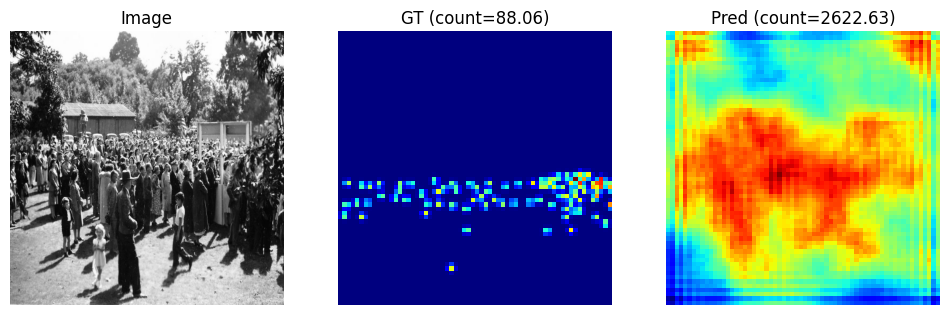

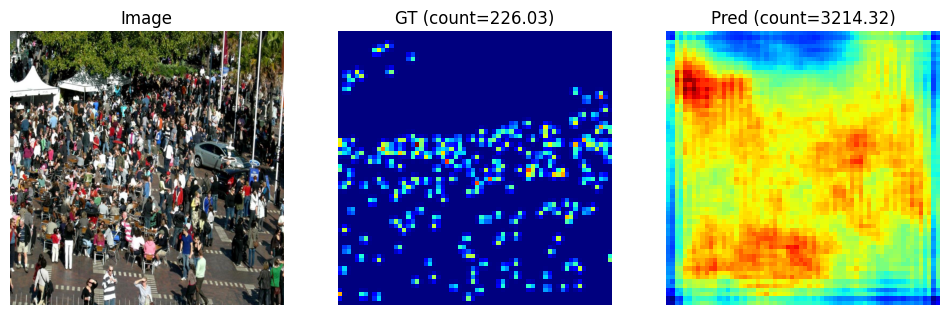

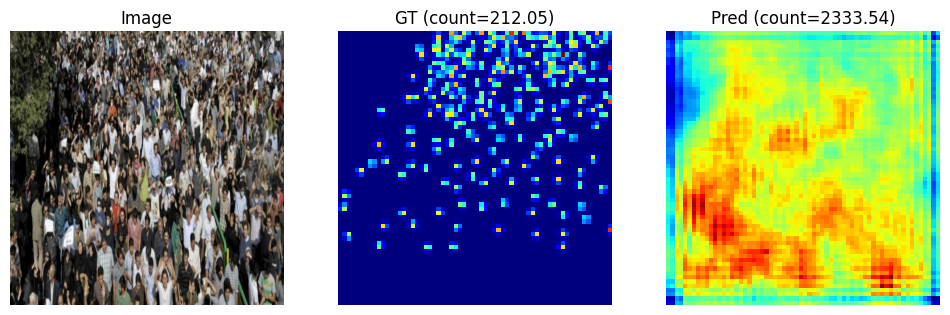

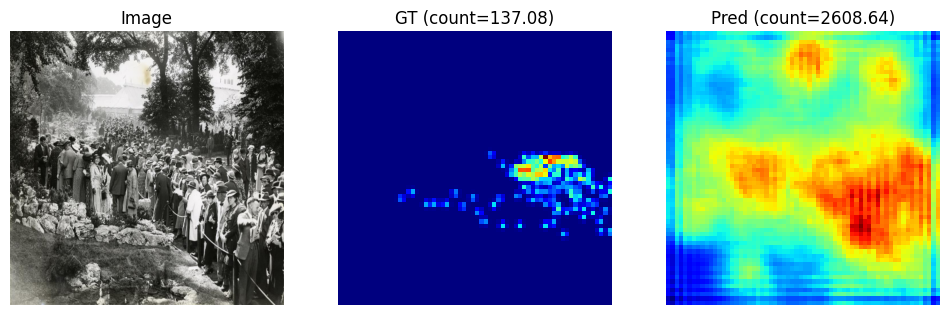

In [33]:
###############################################
# 8) VISUALIZE UP TO 4 SAMPLES (AUTO-FIX VERSION)
###############################################

from pathlib import Path

def show_map(img, gt, pred):
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


# ==================================================
# AUTO-RELOAD TEST DATA IF DATASET IS EMPTY
# ==================================================
if len(test_ds) == 0:
    print("⚠️ Test dataset empty. Reloading TestA data...")

    test_img_dir = Path("preprocessed/TestA/images")
    test_gt_dir  = Path("preprocessed/TestA/gt")

    test_imgs = sorted([str(p) for p in test_img_dir.glob("*.pt")])
    test_gts  = sorted([str(p) for p in test_gt_dir.glob("*.pt")])

    print("Test images found:", len(test_imgs))
    print("Test GTs found   :", len(test_gts))

    test_ds = PTDataset(test_imgs, test_gts)

print("Final Test dataset size:", len(test_ds))


# ==================================================
# RUN VISUALIZATION
# ==================================================
if len(test_ds) == 0:
    print("❌ Test dataset still empty. Check preprocessing paths.")
else:
    num_samples = min(4, len(test_ds))
    for i in range(num_samples):
        img, gt = test_ds[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).cuda())[0].cpu()
        show_map(img, gt, pred)
